## Bayesian Hierarchical Model Example
### K-Drama Ratings
02-2023

#### Background:

Example approach copied from these resources: 

- https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-ratings-of-animation-movies
- https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html

A sample from a tv database was collected on K-drama ratings for 100 different tv dramas released 2003-2021. There are 14 different genres and each drama has a single rating, which is an aggregate of all viewer ratings of that drama. The ratings are likely affected by the type of genre, as some genres are generally favored by the audience or have more options available for viewers to compare against.

#### Business Questions:
- What is the expected average rating for a given genre?
- Understand the differences in ratings between genres
- I have money to invest into a new drama series. Which genre would be a smart decision to invest in?


#### Data:
- Let  Yij denote the overall viewer rating of drama i in genre j
    e.g. Yij = 9.0 Happiness | Action
- Viewer ratings are continuous
- Genre is our grouping variable
- Genre categorization is imprecise since most dramas fall into multiple genres


#### Posterior Distribution:
Viewer Rating ~ Normal(μj, σ, α)

where μj = mean of viewer ratings per each genre j
and σ = a common standard deviation of viewer ratings shared across all genres

_Ituition:_

The μ and σ values for each genre a priori are related and come from the same distribution, but could be very different if the standard deviation of the distribution is wide. 


#### Prior Distribution:
μj ~ Normal(x, y)

σ^2 ~ InverseGamma(a,b)


_Ituition:_

The prior distribution is a model for all average viewer ratings, corresponding to each particular genres within K-drama television, with these 14 genres being a sample.

The prior Normal(x, y) is a communal prior for the means μj which induces sharing of information across ratings from different genres. Because we specify x and y as random variables, this allows each genre to have its own mean estimate and variation between genres. 

The model uses a shared σ for all genres which also induces sharing of information, but is different in that it pools all the genres together, not allowing genres to have their own σ. With this setup, we cannot learn about the differences and similarities among the genre's standard deviation of average rating.



#### Hyper Prior:

x ~ Normal(c,d)

y^2 ~ InverseGamma(e,f)

_Ituition:_

The hyper prior distributions allow us to learn about μj's distribution in the prior and provides information about the population of viewer rating means per genre.

In [1]:
# import packages
import numpy as np
#import statistics
#import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

colors = ['#50CCDE','#87E0CD','#AFE28A', '#E1929B', '#519485','#B570BA','#7c3e81' ]

In [2]:
# Working Directory
os.getcwd()

'C:\\Users\\anneg\\OneDrive - Logic20 20 Inc\\Documents\\Python Scripts'

In [3]:
#### DATA
data=pd.read_csv(r'top100_kdrama.csv')

#### The main columns we will focus on are _Genre_ and _Rating_

In [4]:
# explore data
data.head()

Name  Year of release                   Aired Date  \
0       Move to Heaven             2021                 May 14, 2021   
1    Hospital Playlist             2020  Mar 12, 2020 - May 28, 2020   
2       Flower of Evil             2020  Jul 29, 2020 - Sep 23, 2020   
3  Hospital Playlist 2             2021  Jun 17, 2021 - Sep 16, 2021   
4            My Mister             2018  Mar 21, 2018 - May 17, 2018   

               Aired On  Number of Episode         Network       Duration  \
0                Friday                 10        Netflix         52 min.   
1              Thursday                 12  Netflix,  tvN   1 hr. 30 min.   
2   Wednesday, Thursday                 16            tvN   1 hr. 10 min.   
3              Thursday                 12  Netflix,  tvN   1 hr. 40 min.   
4   Wednesday, Thursday                 16            tvN   1 hr. 17 min.   

                           Content Rating  \
0  18+ Restricted (violence & profanity)    
1                15+ - Teens 15 or older    
2                15+ - Teens 15 or older    
3                15+ - Teens 15 or older    
4                15+ - Teens 15 or older    

                                            Synopsis  \
0  Geu Roo is a young autistic man. He works for ...   
1  The stories of people going through their days...   
2  Although Baek Hee Sung is hiding a dark secret...   
3  Everyday is extraordinary for five doctors and...   
4  Park Dong Hoon is a middle-aged engineer who i...   

                                                Cast  \
0  Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...   
1  Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...   
2  Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...   
3  Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...   
4  Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...   

                                     Genre  \
0                   Life,  Drama,  Family    
1   Friendship,  Romance,  Life,  Medical    
2  Thriller,  Romance,  Crime,  Melodrama    
3   Friendship,  Romance,  Life,  Medical    
4   Psychological,  Life,  Drama,  Family    

                                                Tags Rank  Rating  
0  Autism, Uncle-Nephew Relationship, Death, Sava...   #1     9.2  
1  Strong Friendship, Multiple Mains, Best Friend...   #2     9.1  
2  Married Couple, Deception, Suspense, Family Se...   #3     9.1  
3  Workplace, Strong Friendship, Best Friends, Mu...   #4     9.1  
4  Age Gap, Nice Male Lead, Strong Female Lead, H...   #5     9.1

In [5]:
# create simplified 'Genre' column
data['genre_simple']=data['Genre'].str.split(',').str[0]

#### Note that the simplied genre category (taking the first value from _Genre_) is not a perfect system.
e.g. Hotel Del Luna is not a horror

Better ways to classify genre could be cross-reference multiple data sources and use mode category, or use an unsupervised learning approach to cluster dramas into similar groupings.

In [6]:
data.iloc[[7,12,14,18,21,26,49,55]]


Name  Year of release  \
7          It's Okay to Not Be Okay             2020   
12                        Happiness             2021   
14             Crash Landing on You             2019   
18                           Healer             2014   
21             Hometown Cha-Cha-Cha             2021   
26  Weightlifting Fairy Kim Bok Joo             2016   
49                   Hotel del Luna             2019   
55        Strong Woman Do Bong Soon             2017   

                     Aired Date              Aired On  Number of Episode  \
7   Jun 20, 2020 - Aug  9, 2020      Saturday, Sunday                 16   
12  Nov  5, 2021 - Dec 11, 2021      Friday, Saturday                 12   
14  Dec 14, 2019 - Feb 16, 2020      Sunday, Saturday                 16   
18  Dec  8, 2014 - Feb 10, 2015       Monday, Tuesday                 20   
21  Aug 28, 2021 - Oct 17, 2021      Saturday, Sunday                 16   
26  Nov 16, 2016 - Jan 11, 2017   Wednesday, Thursday                 16   
49  Jul 13, 2019 - Sep  1, 2019      Saturday, Sunday                 16   
55  Feb 24, 2017 - Apr 15, 2017      Friday, Saturday                 16   

           Network       Duration            Content Rating  \
7   Netflix,  tvN   1 hr. 15 min.  15+ - Teens 15 or older    
12            tvN    1 hr. 5 min.  15+ - Teens 15 or older    
14  Netflix,  tvN   1 hr. 25 min.  15+ - Teens 15 or older    
18           KBS2         60 min.  15+ - Teens 15 or older    
21  Netflix,  tvN   1 hr. 20 min.  15+ - Teens 15 or older    
26            MBC         60 min.  15+ - Teens 15 or older    
49            tvN   1 hr. 20 min.  15+ - Teens 15 or older    
55           jTBC    1 hr. 7 min.  15+ - Teens 15 or older    

                                             Synopsis  \
7   Moon Gang Tae is a community health worker at ...   
12  A deadly new strain of a virus is spreading th...   
14  After getting into a paragliding accident, Sou...   
18  Seo Jung Hoo is a special kind of night courie...   
21  Hometown Cha-Cha-Cha is a love story set in th...   
26  Bok Joo is a weightlifter who is pursuing her ...   
49  Nestled deep in the heart of Seoul’s thriving ...   
55  Do Bong Soon is a petite, unemployed woman who...   

                                                 Cast  \
7   Kim Soo Hyun, Seo Yea Ji, Oh Jung Se, Park Gyu...   
12  Han Hyo Joo, Park Hyung Sik, Jo  Woo Jin, Lee ...   
14  Hyun Bin, Son Ye Jin, Seo Ji Hye, Kim Jung Hyu...   
18  Ji Chang Wook, Park Min Young, Yoo Ji Tae, Kim...   
21  Shin Min Ah, Kim Seon Ho, Lee Sang Yi, In Gyo ...   
26  Lee Sung Kyung, Nam Joo Hyuk, Lee Jae Yoon, Ky...   
49  IU, Yeo Jin Goo, Shin Jung Keun, Bae Hae Seon,...   
55  Park Bo Young, Park Hyung Sik, Kim Ji Soo, Jun...   

                                                Genre  \
7           Psychological,  Comedy,  Romance,  Drama    
12               Action,  Thriller,  Drama,  Fantasy    
14           Military,  Comedy,  Romance,  Political    
18             Action,  Thriller,  Mystery,  Romance    
21                           Comedy,  Romance,  Life    
26                 Comedy,  Romance,  Youth,  Sports    
49               Horror,  Comedy,  Romance,  Fantasy    
55  Action,  Thriller,  Comedy,  Romance,  Drama, ...   

                                                 Tags Rank  Rating  \
7   Sibling Relationship, Melodrama, Mental Health...   #8     9.0   
12  Disease, Strong Female Lead, Survival, Virus, ...  #13     9.0   
14  North And South Korea, Star Crossed Lovers, Lo...  #15     9.0   
18  Double Identity, Hidden Identity, Smart Male L...  #19     8.9   
21  Rural Village, Dentist, Healing, Kind-hearted ...  #22     8.8   
26  College Life, Dream, Friends To Lovers, Weight...  #27     8.8   
49  Boss-Employee Relationship, Immortal, Strong F...  #50     8.7   
55  Strong Female Lead, Female Lead Action Scenes,...  #56     8.7   

     genre_simple  
7   Psychological  
12         Action  
14       Military  
18         Action  


#### Descriptive Statistics / EDA of dataset:

In [7]:
data.describe()

Year of release  Number of Episode      Rating
count       100.000000         100.000000  100.000000
mean       2017.970000          19.070000    8.723000
std           2.869044          12.378096    0.174573
min        2003.000000           6.000000    8.500000
25%        2017.000000          16.000000    8.600000
50%        2019.000000          16.000000    8.700000
75%        2020.000000          20.000000    8.800000
max        2021.000000         100.000000    9.200000

In [8]:
print("Number of obs: ", data.shape[0])
print("Average Rating: ", data.Rating.mean())
print("Min Rating: ", data.Rating.min())
print("Max Rating: ", data.Rating.max())

Number of obs:  100
Average Rating:  8.723000000000006
Min Rating:  8.5
Max Rating:  9.2


Text(0, 0.5, 'Density')

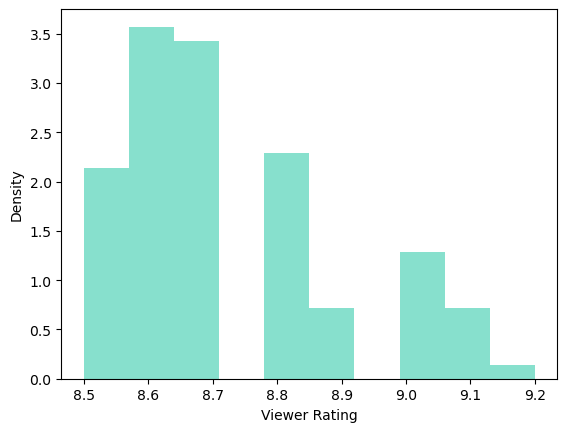

In [9]:
plt.hist(data.Rating, color=colors[1], density=True)
plt.xlabel("Viewer Rating")
plt.ylabel("Density")

#### Note the data limitations for some of the genre categories (e.g. _Food_, _Drama_). Bayesian is a great approach for small datasets.

It would be difficult to learn much about the mean rating for genres with only 1 observation. Here, we can improve the estimate of the mean rating by using hierarchical modeling, which utilizes some pooling of the entire dataset.

In [10]:
# Genre frequency list
data['genre_simple'].value_counts()

Thriller         21
Action           19
Comedy           15
Friendship        9
Mystery           8
Historical        7
Psychological     6
Life              3
Horror            3
Romance           3
Military          2
Business          2
Drama             1
Food              1
Name: genre_simple, dtype: int64

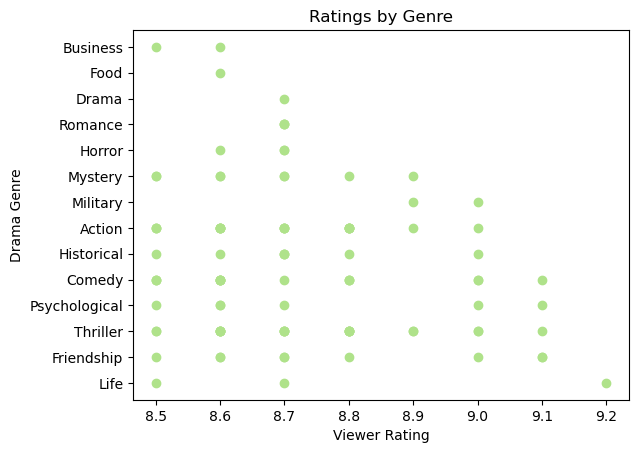

In [11]:
plt.scatter(x=data.Rating, y=data.genre_simple, color=colors[2])
plt.xlabel("Viewer Rating")
plt.ylabel("Drama Genre")
plt.title("Ratings by Genre")
plt.show()

<AxesSubplot:xlabel='Rating', ylabel='genre_simple'>

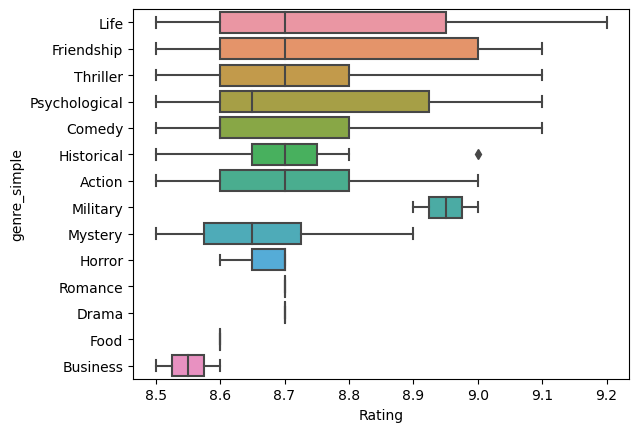

In [12]:
sns.boxplot(data = data, y = "genre_simple", x = "Rating")

In [13]:
means = data.groupby('genre_simple')['Rating'].mean().reset_index()
sds = data.groupby('genre_simple')['Rating'].std().reset_index()
ns = data.groupby('genre_simple')['Rating'].size().reset_index()

In [14]:
# Table of rating stats by genre
genre_stats=pd.merge(pd.merge(means,sds, on='genre_simple', how='left'), ns, on='genre_simple', how='left').rename(columns = {'Rating_x':'Mean','Rating_y':'SD','Rating':'N'})
genre_stats

genre_simple      Mean        SD   N
0          Action  8.694737  0.139338  19
1        Business  8.550000  0.070711   2
2          Comedy  8.713333  0.195911  15
3           Drama  8.700000       NaN   1
4            Food  8.600000       NaN   1
5      Friendship  8.788889  0.226078   9
6      Historical  8.714286  0.157359   7
7          Horror  8.666667  0.057735   3
8            Life  8.800000  0.360555   3
9        Military  8.950000  0.070711   2
10        Mystery  8.662500  0.140789   8
11  Psychological  8.750000  0.242899   6
12        Romance  8.700000  0.000000   3
13       Thriller  8.747619  0.166190  21

### The Model:

- import PyMC package to faciliate the model setup and the MCMC approach to parameter estimation
- reiterate the posterior distribution function, prior distributions, and hyperprior distributions
- The model = the complete hierarchical framework of posterior, priors, and hyper-priors
- The likelihood function = specified shape of the observation data; the posterior distribution; e.g. Viewer Rating ~ Normal(μj, σ^2)
- PyMC runs on an PyTensor graph under the hood


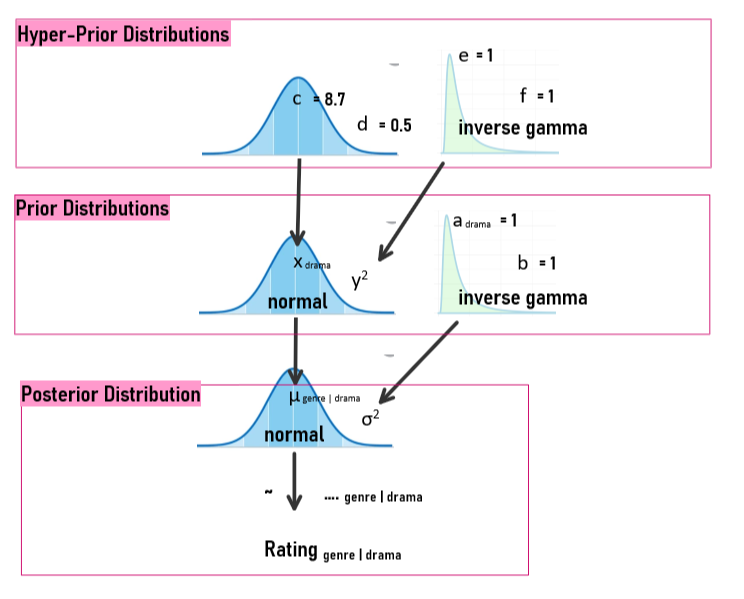

In [15]:
import pymc as pm #package to run the MCMC sampling algorithm
import arviz as az #package for exploratory analysis of Bayesian models
from pymc import model_to_graphviz
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.2


In [16]:
import pytensor.tensor as pt

In [17]:
plt.rcParams["figure.constrained_layout.use"] = True
genre_idx, genres = pd.factorize(data["genre_simple"], sort=True)
coords = {"genre": genres}

### Weakly Informative Priors, with NUTS sampler:

- used truncated for Normal distributions since ratings cannot be over 10 or below 1

In [18]:
# priors
# μj ~ Normal(x, y)
# σ^2 ~ InverseGamma(a,b)
a=1
b=1

# Hyperpriors:
# x ~ Normal(c,d)
# y^2 ~ InverseGamma(e,f)
c=8
d=.5
e=1
f=1

In [19]:
with pm.Model(coords=coords) as model:
    # constant data
    genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Normal(c,d)
    # y^2 ~ InverseGamma(e,f)
    for_prior_x = pm.TruncatedNormal("for_prior_x", mu=c, sigma=d,lower=1,upper=10)  # assign c and d
    for_prior_y2 = pm.InverseGamma("for_prior_y2", alpha=e, beta=f)  # assign e and f
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ InverseGamma(a,b)
    for_posterior_mu = pm.TruncatedNormal("for_posterior_mu", mu=for_prior_x, sigma=pt.sqrt(for_prior_y2), lower=1,upper=10, dims="genre")
    for_posterior_sd2=pm.InverseGamma("for_posterior_sd2",alpha=a, beta=b, dims="genre") #define a and b
        
    # Create a named deterministic variable
    # Deterministic nodes are only deterministic given all of their inputs, i.e. they don’t add randomness to the model
    # They are generally used to record an intermediary result
    # If you want to do a formula and track its value in the sampling trace, then use a deterministic node
    diff_from_avg = pm.Deterministic("diff_from_avg", for_posterior_mu - pt.mean(for_posterior_mu), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating = for_posterior_mu[genre_idx]
    genre_sd_rating = pt.sqrt(for_posterior_sd2)[genre_idx]
        
    
    # likelihood of observed data
    avg_rating = pm.TruncatedNormal(
        "avg_rating",
        mu=genre_avg_rating,   #separate mean for each genre
        sigma=genre_sd_rating,  #shared stdev across all genres
        lower=1,
        upper=10,
        observed=data["Rating"],
        dims=("drama"),
    )
    

    # Uses NUTS sampler
    # see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html
    trace = pm.sample(1000, tune=1500, cores=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [for_prior_x, for_prior_y2, for_posterior_mu, for_posterior_sd2]


Sampling 5 chains for 1_500 tune and 1_000 draw iterations (7_500 + 5_000 draws total) took 72 seconds.


### Model Output:
- GraphViz image of model structure
- Trace summary table
- Trace Plot of Hyper-priors
- Trace Plot of Priors
- Plot 1 = Posterior Distribution vs Observational Data
- Plot 2 = Posterior Difference from Overall Avg. Rating

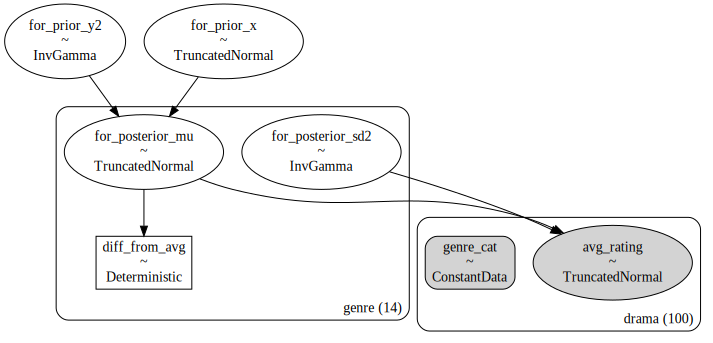

In [20]:
# GraphViz image of model structure
model_to_graphviz(model)

In [21]:
# Trace summary table
trace_summary=az.summary(trace, kind="stats", round_to=2)
trace_summary

mean     sd  hdi_3%  hdi_97%
for_prior_x                       8.74   0.18    8.42     9.08
for_prior_y2                      0.29   0.18    0.09     0.60
for_posterior_mu[Action]          8.70   0.08    8.54     8.85
for_posterior_mu[Business]        8.72   0.42    7.94     9.52
for_posterior_mu[Comedy]          8.72   0.11    8.51     8.93
for_posterior_mu[Drama]           8.77   0.47    7.88     9.68
for_posterior_mu[Food]            8.74   0.47    7.85     9.64
for_posterior_mu[Friendship]      8.82   0.20    8.46     9.20
for_posterior_mu[Historical]      8.76   0.24    8.32     9.21
for_posterior_mu[Horror]          8.78   0.38    8.07     9.52
for_posterior_mu[Life]            8.86   0.39    8.10     9.59
for_posterior_mu[Military]        8.88   0.43    8.12     9.71
for_posterior_mu[Mystery]         8.71   0.21    8.32     9.12
for_posterior_mu[Psychological]   8.82   0.29    8.31     9.41
for_posterior_mu[Romance]         8.80   0.39    8.03     9.51
for_posterior_mu[Thriller]        8.75   0.08    8.61     8.90
for_posterior_sd2[Action]         0.13   0.05    0.06     0.22
for_posterior_sd2[Business]       1.84   9.01    0.12     4.39
for_posterior_sd2[Comedy]         0.19   0.09    0.08     0.34
for_posterior_sd2[Drama]          4.00  39.31    0.10     7.27
for_posterior_sd2[Food]           4.55  60.36    0.12     7.49
for_posterior_sd2[Friendship]     0.35   0.26    0.10     0.76
for_posterior_sd2[Historical]     0.42   0.35    0.09     0.95
for_posterior_sd2[Horror]         1.08   2.06    0.09     2.89
for_posterior_sd2[Life]           1.15   1.71    0.13     2.91
for_posterior_sd2[Military]       2.02  18.00    0.13     4.27
for_posterior_sd2[Mystery]        0.37   0.38    0.08     0.79
for_posterior_sd2[Psychological]  0.58   0.60    0.10     1.37
for_posterior_sd2[Romance]        1.00   1.28    0.13     2.72
for_posterior_sd2[Thriller]       0.13   0.04    0.06     0.21
diff_from_avg[Action]            -0.08   0.13   -0.31     0.17
diff_from_avg[Business]          -0.05   0.38   -0.74     0.71
diff_from_avg[Comedy]            -0.05   0.15   -0.35     0.21
diff_from_avg[Drama]              0.00   0.43   -0.82     0.83
diff_from_avg[Food]              -0.03   0.43   -0.85     0.76
diff_from_avg[Friendship]         0.04   0.20   -0.33     0.44
diff_from_avg[Historical]        -0.01   0.23   -0.44     0.45
diff_from_avg[Horror]             0.00   0.35   -0.69     0.65
diff_from_avg[Life]               0.08   0.35   -0.57     0.78
diff_from_avg[Military]           0.11   0.39   -0.65     0.83
diff_from_avg[Mystery]           -0.06   0.22   -0.47     0.34
diff_from_avg[Psychological]      0.05   0.28   -0.46     0.58
diff_from_avg[Romance]            0.02   0.36   -0.63     0.72
diff_from_avg[Thriller]          -0.02   0.13   -0.26     0.21

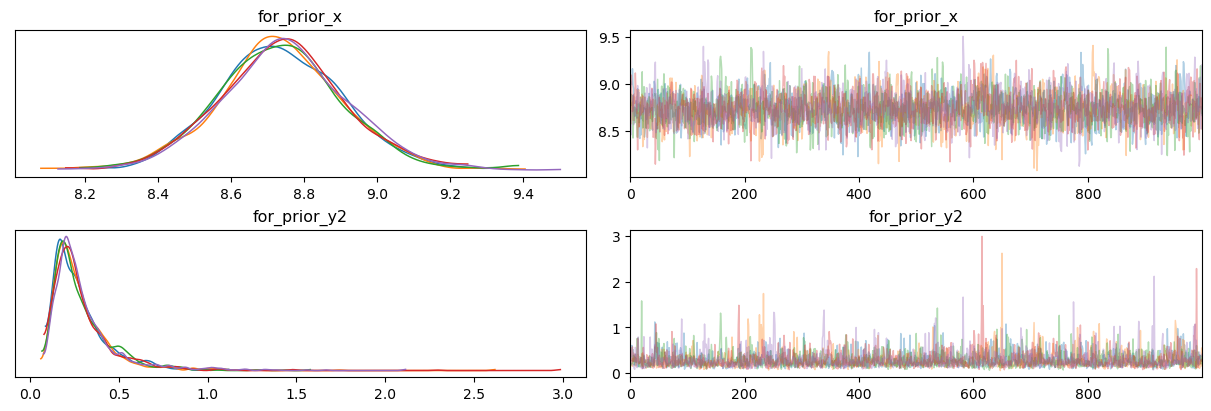

In [22]:
# Trace Plot of Hyper-priors
trace_plot_hyperpriors = az.plot_trace(trace, var_names=["for_prior_x", "for_prior_y2"], compact=False);

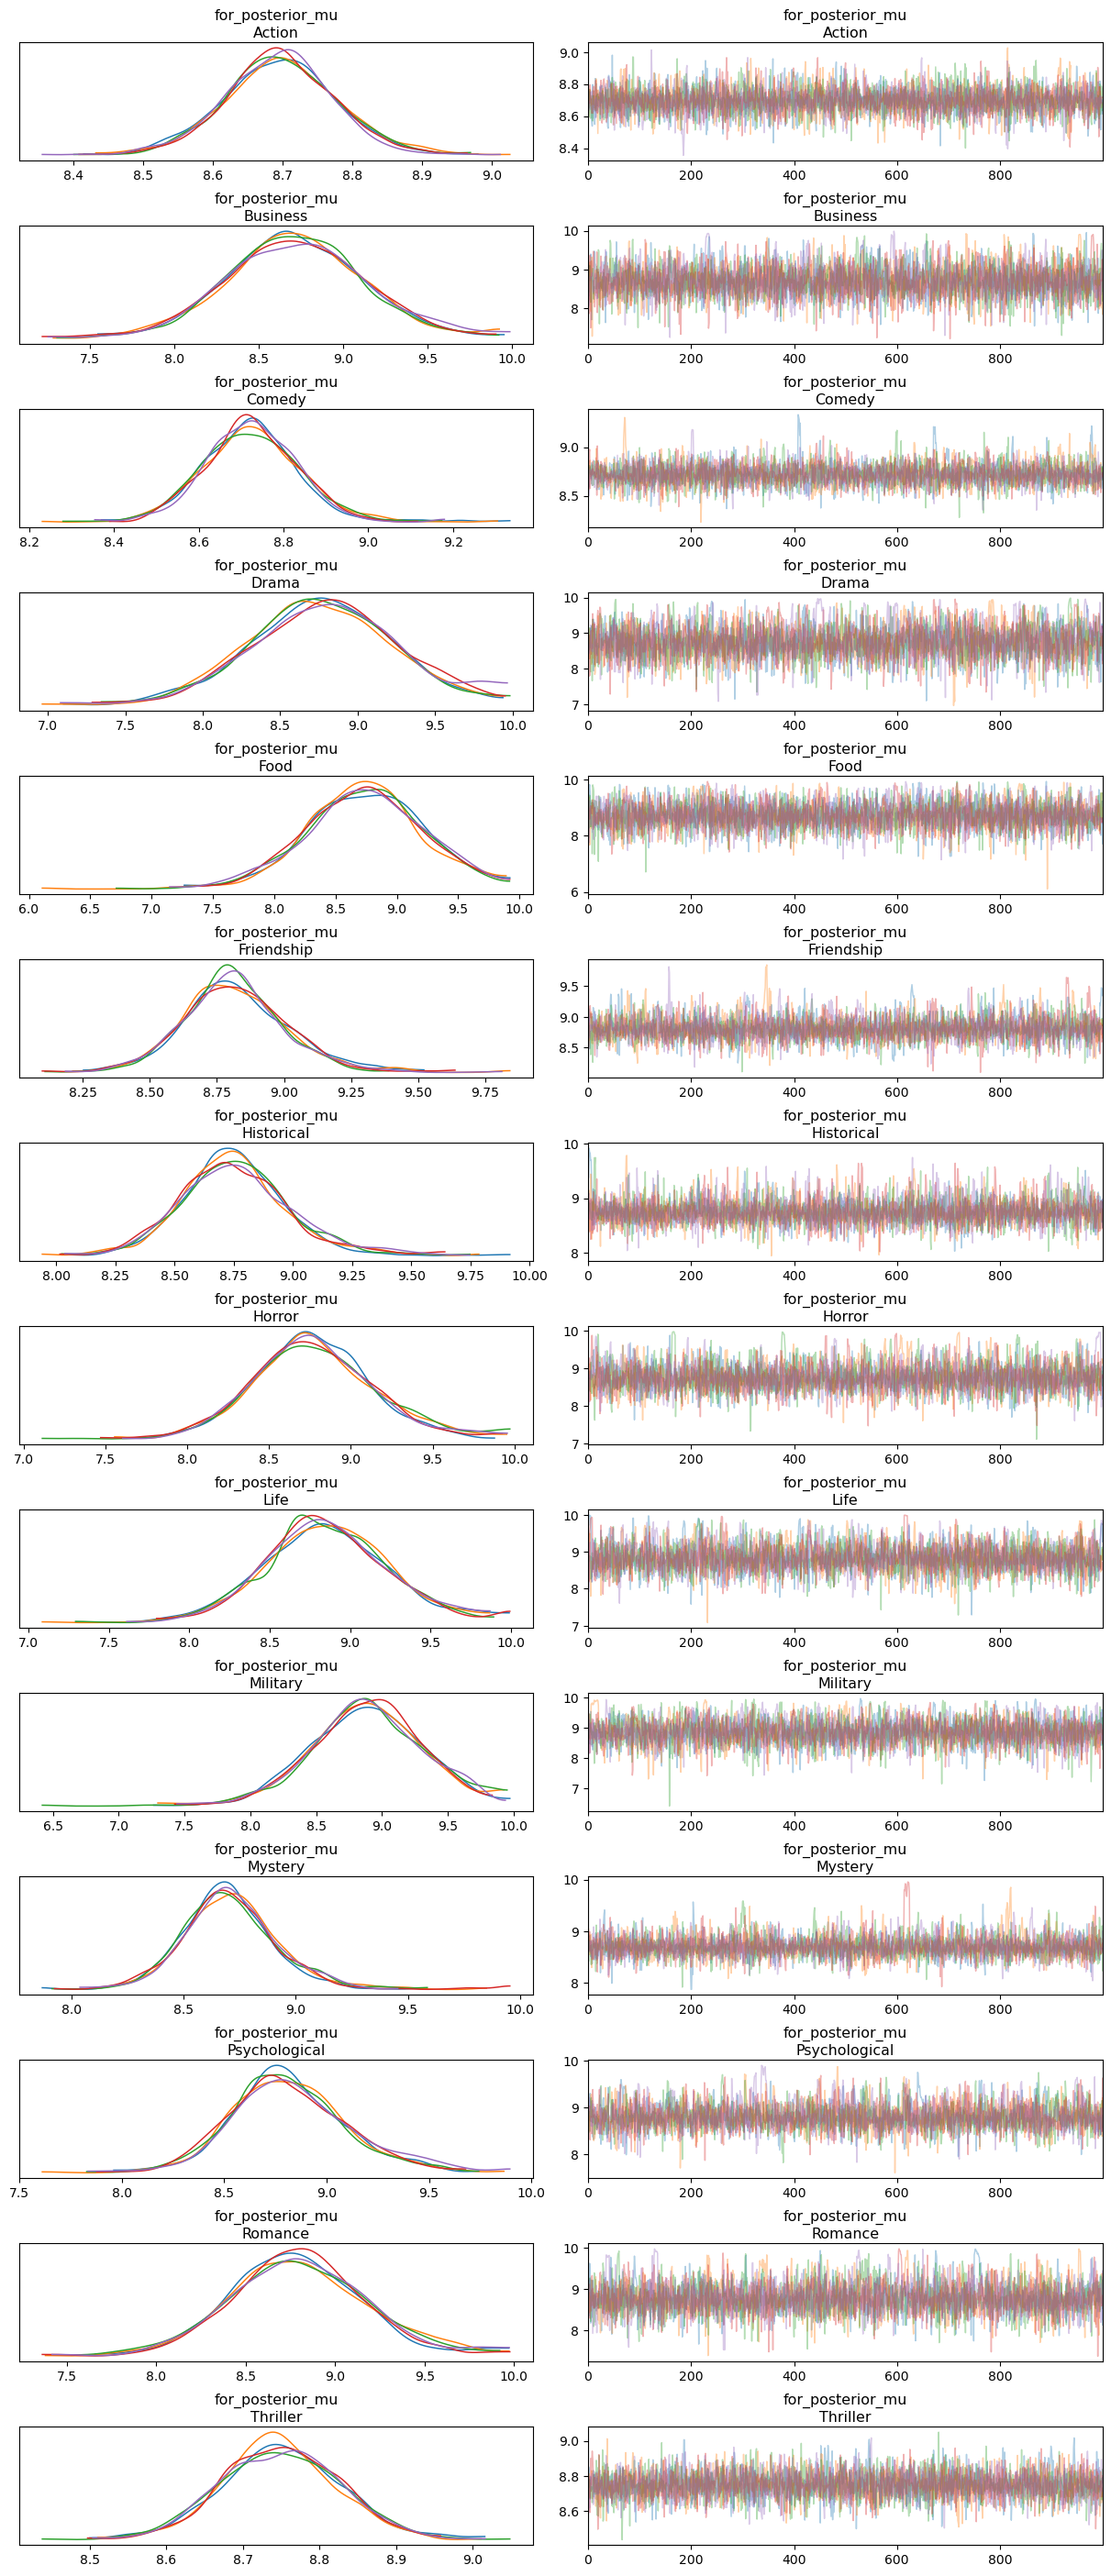

In [23]:
# Trace Plot of Priors
trace_plot_priors = az.plot_trace(trace, var_names=["for_posterior_mu"], compact=False);

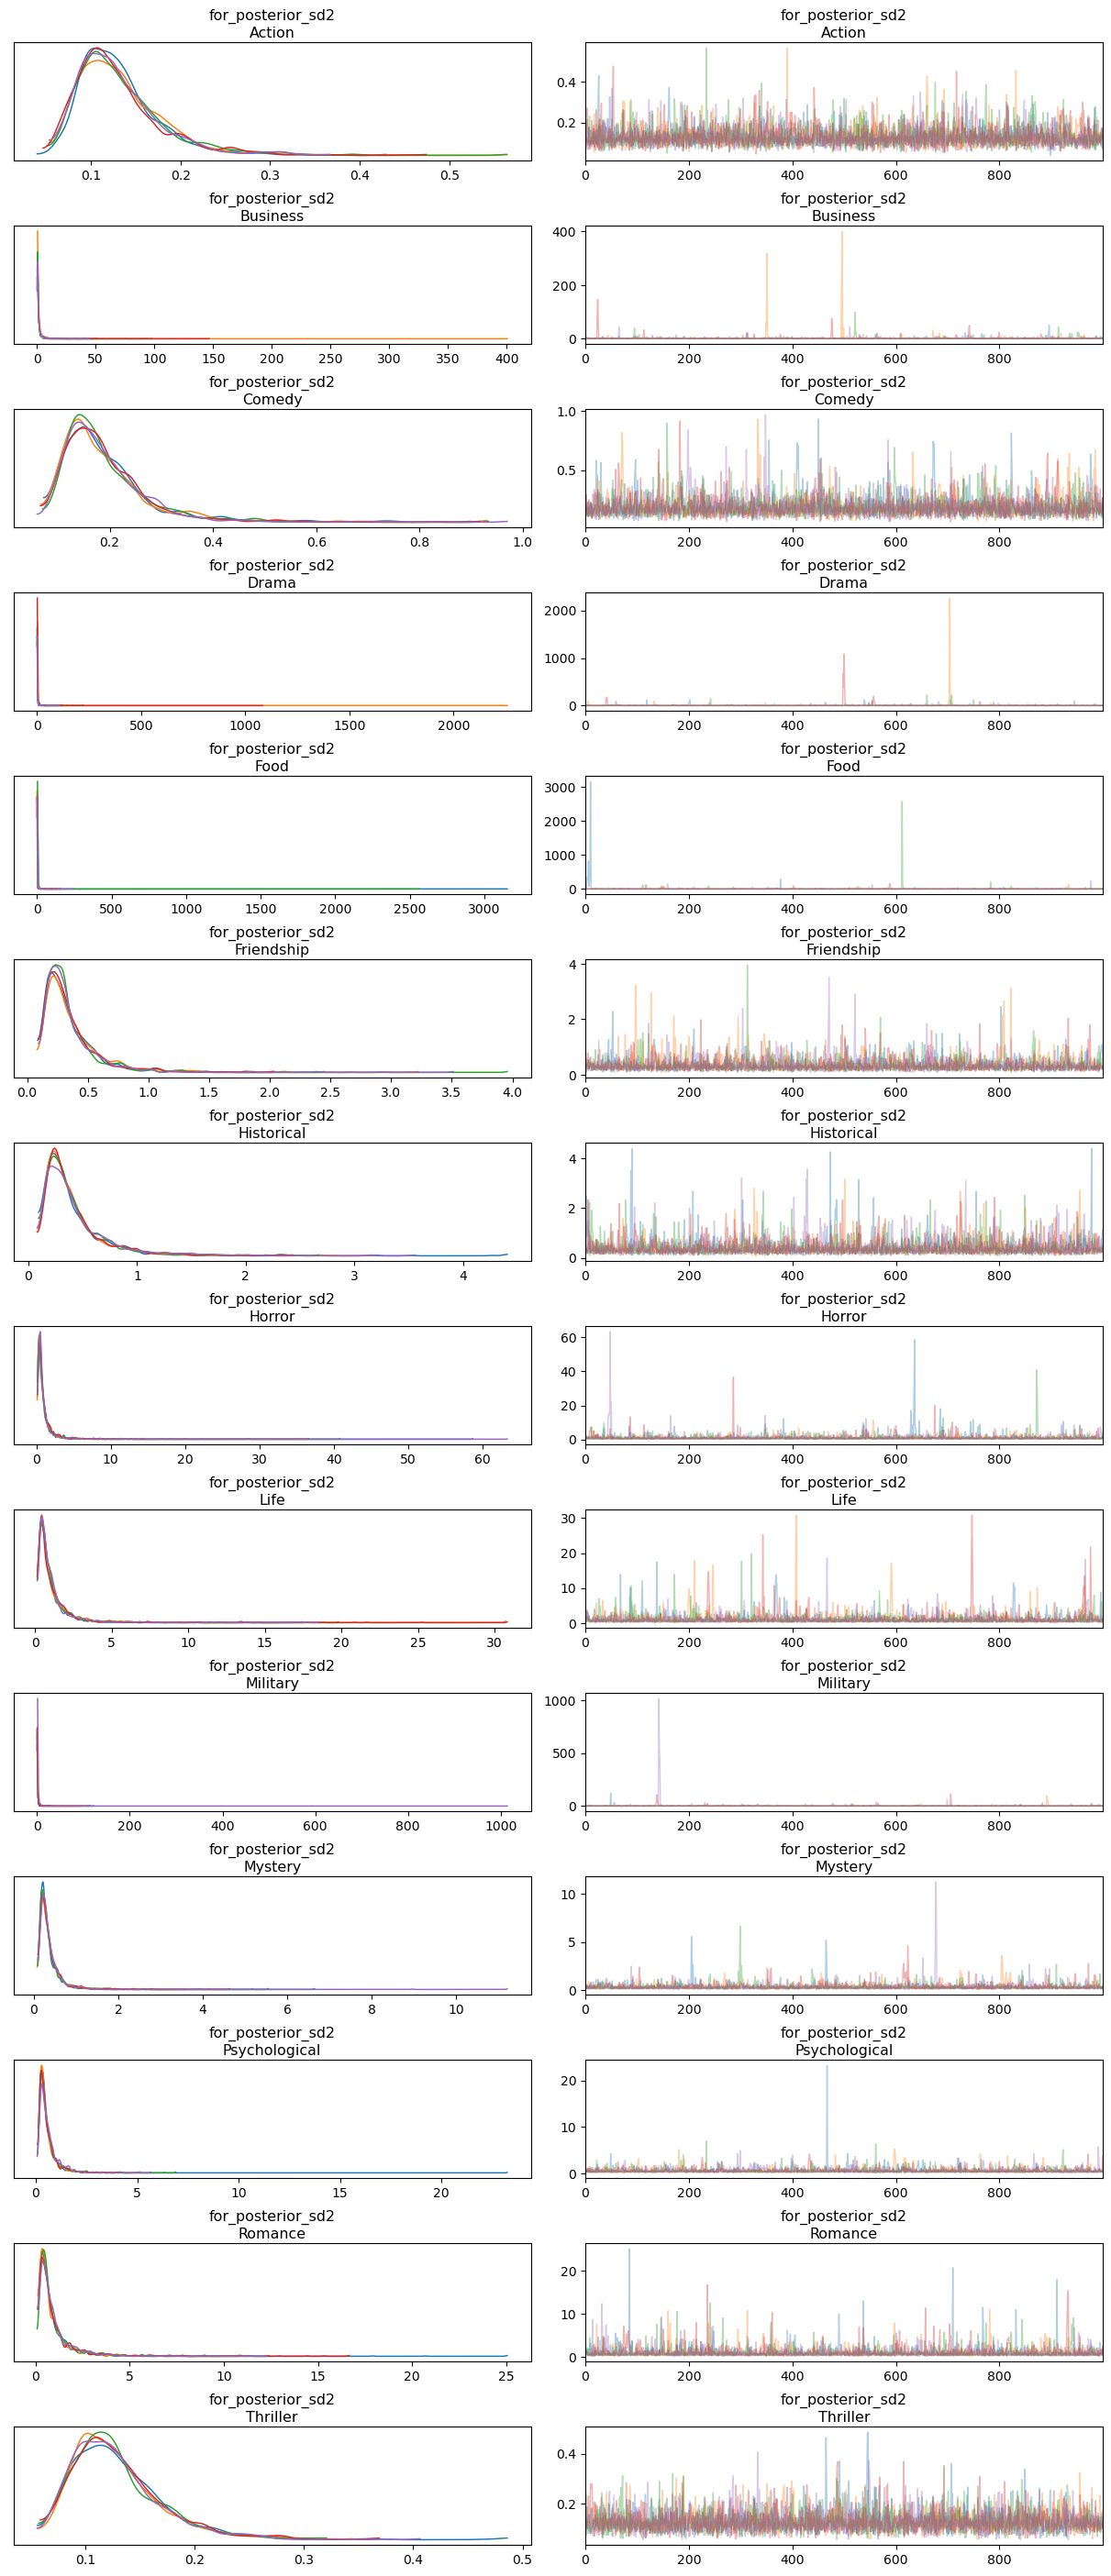

In [24]:
# Trace Plot of Priors
trace_plot_priors = az.plot_trace(trace, var_names=["for_posterior_sd2"], compact=False);

In [25]:
#When using NUTS, the energy plot helps to assess problems of convergence. It summarizes how efficiently the random process explores the posterior
#The plot shows the energy and the energy transition matrix, which should be well-matched.
#az.plot_energy(trace, figsize=(6, 4));

In [26]:
#az.summary(trace, kind="diagnostics")

In [27]:
# not needed in output
# HDI = high-density intervals
# The HDI ncludes the most credible values
trace_hdi = az.hdi(trace)
#trace_hdi["for_posterior_mu"]

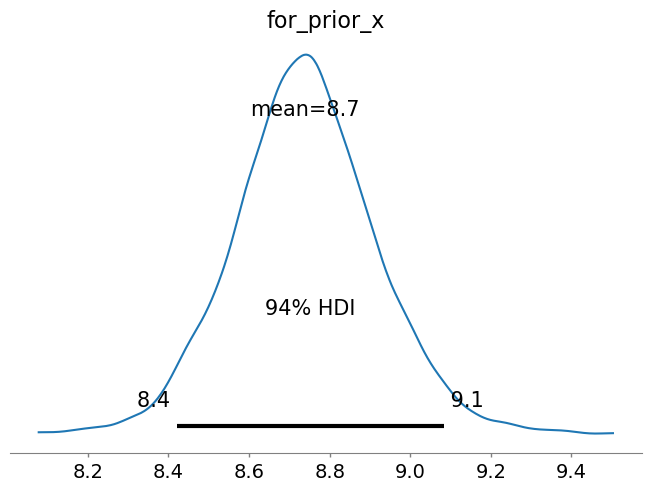

In [28]:
# Estimated Normal distribution for Hyper-prior x
az.plot_posterior(trace, var_names=["for_prior_x"]);

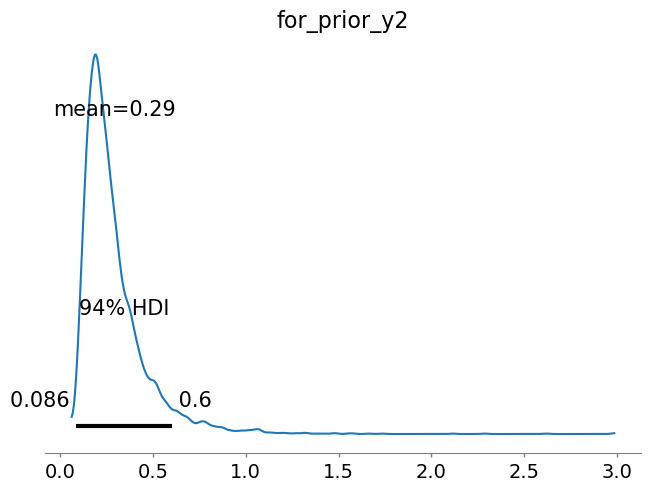

In [29]:
# Estimated InverseGamme distribution for Hyper-prior y^2
az.plot_posterior(trace, var_names=["for_prior_y2"]);

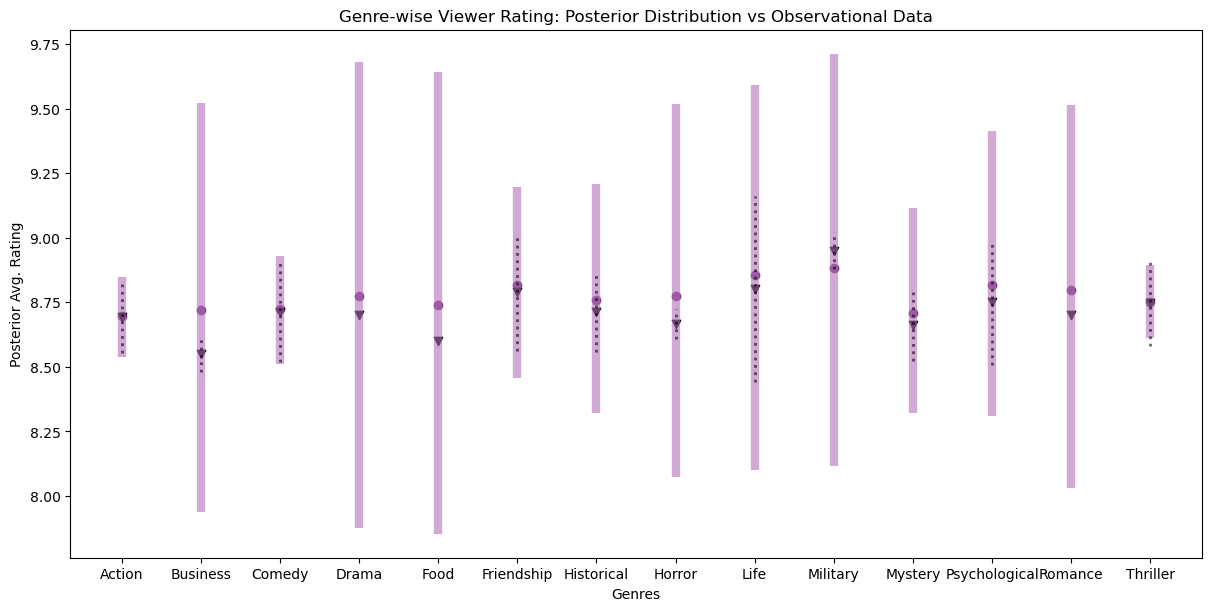

In [30]:
# Plot 1

_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["for_posterior_mu"].mean(dim=("chain", "draw")), color=colors[6])
ax.vlines(
    genres,
    trace_hdi["for_posterior_mu"].sel({"hdi": "lower"}),
    trace_hdi["for_posterior_mu"].sel({"hdi": "higher"}),
    color=colors[5],
    lw=6,
    alpha=0.6,
)

ax.scatter(genre_stats.genre_simple, genre_stats.Mean, color="black",marker="v")
ax.vlines(
    genre_stats.genre_simple,
    genre_stats.Mean - genre_stats.SD,
    genre_stats.Mean + genre_stats.SD,
    color="black",
    lw=2,
    alpha=0.6,
    linestyles='dotted'
)

ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating")
ax.set_title("Genre-wise Viewer Rating: Posterior Distribution vs Observational Data");

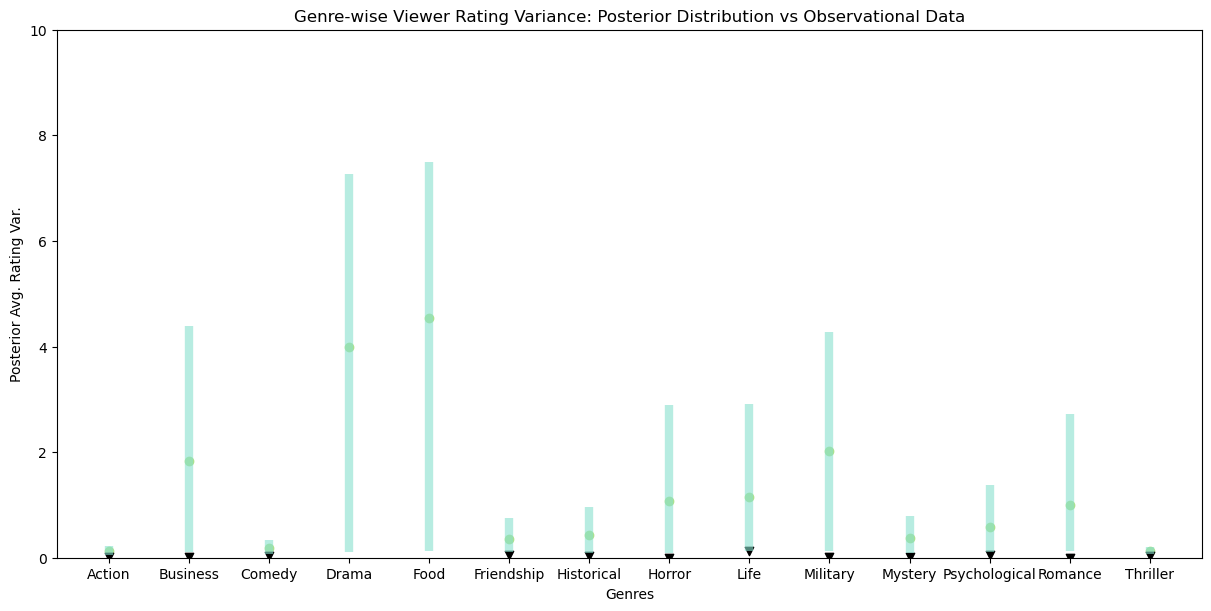

In [31]:
# Plot 1

_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["for_posterior_sd2"].mean(dim=("chain", "draw")), color=colors[2])
ax.vlines(
    genres,
    trace_hdi["for_posterior_sd2"].sel({"hdi": "lower"}),
    trace_hdi["for_posterior_sd2"].sel({"hdi": "higher"}),
    color=colors[1],
    lw=6,
    alpha=0.6,
)

ax.scatter(genre_stats.genre_simple, genre_stats.SD**2, color="black",marker="v")
ax.set_ylim(0,10)
ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating Var.")
ax.set_title("Genre-wise Viewer Rating Variance: Posterior Distribution vs Observational Data");

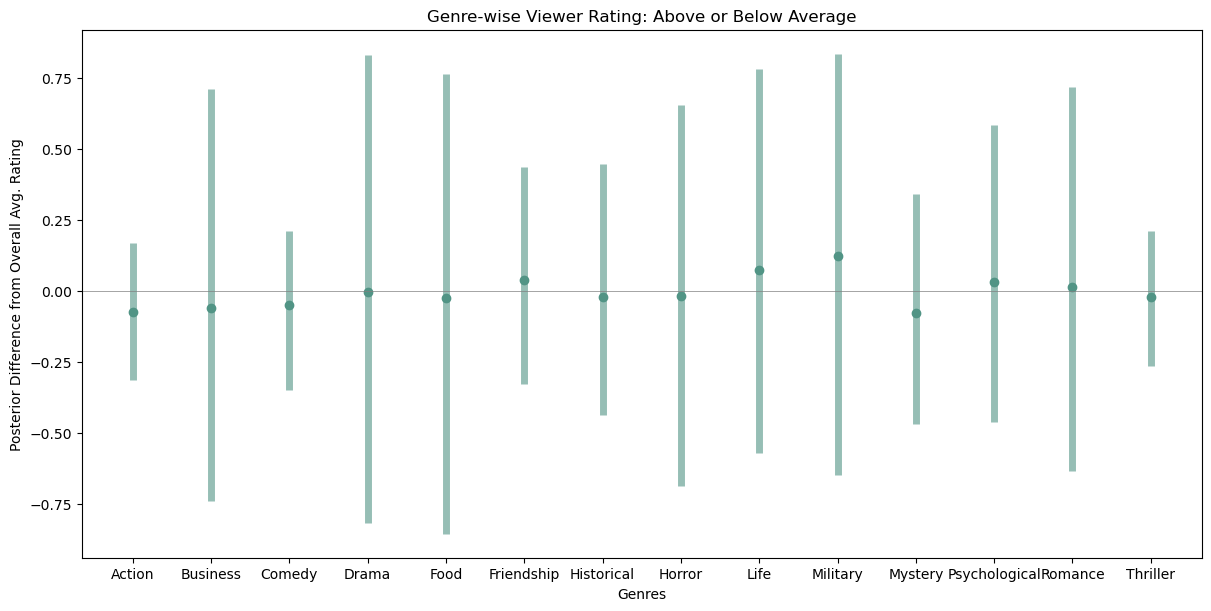

In [32]:
# Plot 2

_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["diff_from_avg"].median(dim=("chain", "draw")), color=colors[4])
ax.vlines(
    genres,
    trace_hdi["diff_from_avg"].sel({"hdi": "lower"}),
    trace_hdi["diff_from_avg"].sel({"hdi": "higher"}),
    color=colors[4],
    lw=5,
    alpha=0.6,
)
ax.axhline(0, color="grey",lw=.5,)
ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Difference from Overall Avg. Rating")
ax.set_title("Genre-wise Viewer Rating: Above or Below Average");

### Model Evaluation: Posterior Predictive Check

If our posterior distribution is a good fit then we should be able to use it to generate data that looks a lot like the observational data. This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points. The closer to the original data the better.

In [33]:
# posterior predictive check: generate data
# 4000 generated data sets using a different parameter setting from the posterior
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)

Sampling: [avg_rating]


In [34]:
trace.posterior_predictive

<xarray.Dataset>
Dimensions:     (chain: 5, draw: 1000, drama: 100)
Coordinates:
  * chain       (chain) int32 0 1 2 3 4
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * drama       (drama) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    avg_rating  (chain, draw, drama) float64 8.961 9.324 8.291 ... 8.836 6.893
Attributes:
    created_at:                 2023-03-10T16:41:28.557489
    arviz_version:              0.15.0
    inference_library:          pymc
    inference_library_version:  5.0.2

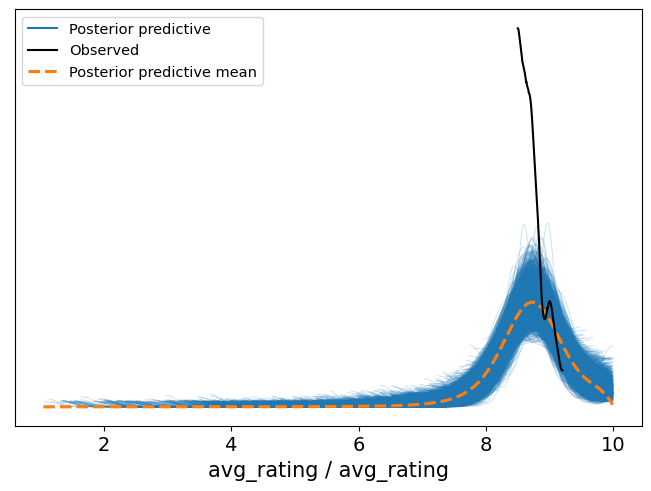

In [35]:
# visualize if model can reproduce the patterns observed in the real data
az.plot_ppc(trace);

### Sensitivity Analysis

Let's check the sensitivity of our model to different priors. We will substitute all hyper-priors and priors with Uniform distribution.

#### Diffuse Priors, with NUTS sampler:

In [37]:
# diffuse priors
# μj ~ Uniform(lower, upper)
# σ^2 ~ Uniform(a,b)
a_=0.1
b_=25

# diffuse Hyperpriors:
# lower ~ Uniform(c,d)
# Upper ~ Uniform(e,f)
c_=1
d_=5
e_=6
f_=10

In [38]:
with pm.Model(coords=coords) as model_diffuse:
    # constant data
    genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?
    
    # Hyperpriors:
    # x ~ Uniform(c,d)
    # y^2 ~ Uniform(e,f)
    for_prior_lower = pm.Uniform("for_prior_lower", lower=c_, upper=d_)  # assign c and d
    for_prior_upper = pm.Uniform("for_prior_upper", lower=e_, upper=f_)  # assign e and f
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ Uniform(a,b)
    for_posterior_mu = pm.Uniform("for_posterior_mu", lower=for_prior_lower, upper=for_prior_upper, dims="genre")
    for_posterior_sd2=pm.Uniform("for_posterior_sd2",lower=a_, upper=b_, dims="genre") #define a and b
        
    # Create a named deterministic variable
    diff_from_avg_diffuse = pm.Deterministic("diff_from_avg", for_posterior_mu - pt.mean(for_posterior_mu), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating_diffuse = for_posterior_mu[genre_idx]
    genre_sd_rating_diffuse = pt.sqrt(for_posterior_sd2[genre_idx])
    
    
    # likelihood of observed data
    avg_rating_diffuse = pm.TruncatedNormal(
        "avg_rating",
        mu=genre_avg_rating_diffuse,   #separate mean for each genre
        sigma=genre_sd_rating_diffuse,  #shared stdev across all genres
        lower=1,
        upper=10,
        observed=data["Rating"],
        dims=("drama"),
    )
    

    # Uses NUTS sampler
    # see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html

    trace_diffuse = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [for_prior_lower, for_prior_upper, for_posterior_mu, for_posterior_sd2]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 125 seconds.


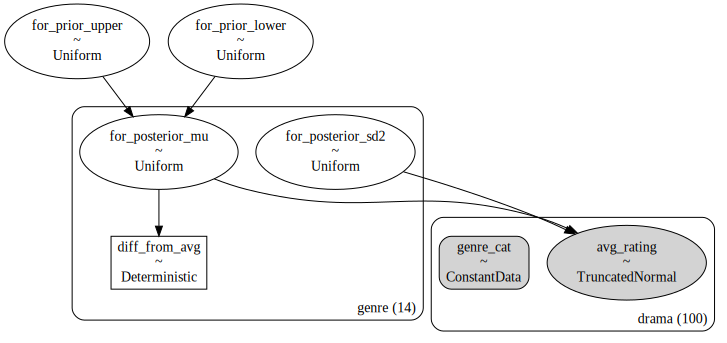

In [39]:
model_to_graphviz(model_diffuse)

C:\Users\anneg\anaconda3\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


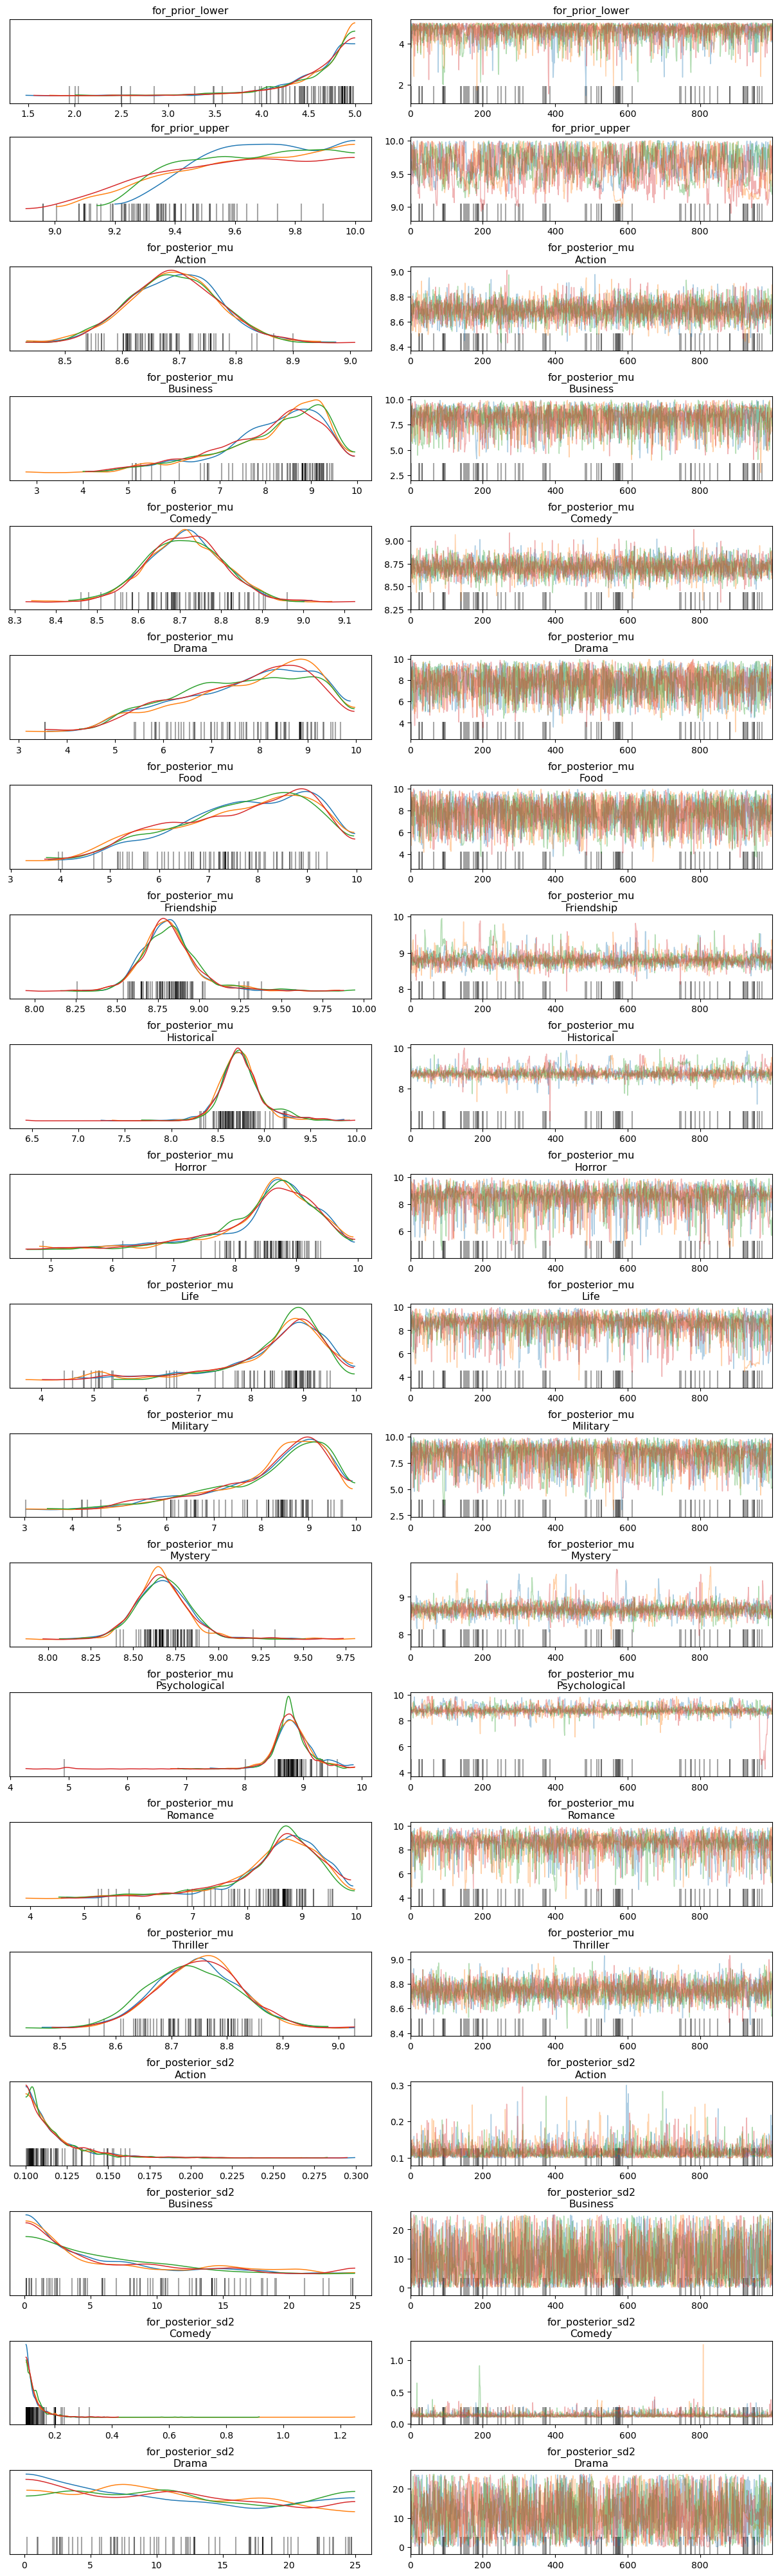

In [40]:
# Trace Plot of Priors
az.plot_trace(trace_diffuse, var_names=["for_prior_lower","for_prior_upper","for_posterior_mu","for_posterior_sd2"], compact=False);

In [41]:
# not needed in output
# HDI = high-density intervals
# short credible intervals containing the posterior mass in a single figure
trace_hdi_diffuse = az.hdi(trace_diffuse)
trace_hdi_diffuse["for_posterior_mu"]

<xarray.DataArray 'for_posterior_mu' (genre: 14, hdi: 2)>
array([[8.53620028, 8.82836037],
       [5.81926041, 9.89799007],
       [8.54403681, 8.88959883],
       [5.22834966, 9.73293026],
       [5.14778064, 9.71008221],
       [8.49028298, 9.15733121],
       [8.33578043, 9.26464633],
       [6.67140092, 9.88344506],
       [6.46576631, 9.89830679],
       [5.87184278, 9.93120986],
       [8.37271473, 8.97866167],
       [8.29592891, 9.56678474],
       [6.60667479, 9.87500255],
       [8.60586779, 8.88888564]])
Coordinates:
  * genre    (genre) <U13 'Action' 'Business' 'Comedy' ... 'Romance' 'Thriller'
  * hdi      (hdi) <U6 'lower' 'higher'

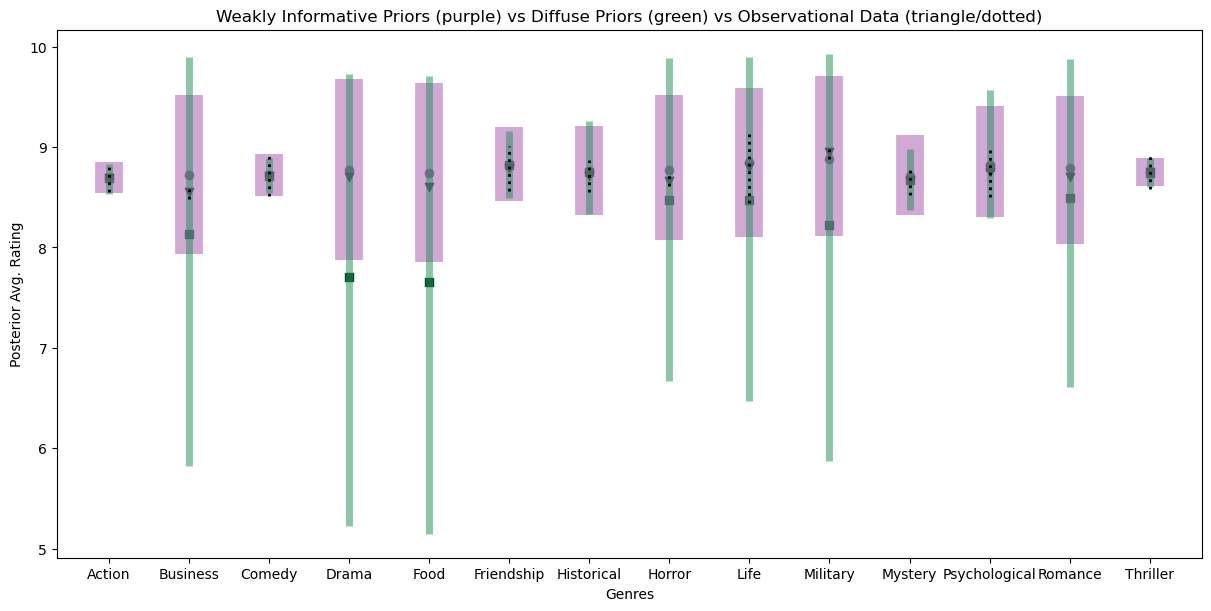

In [42]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(genres, trace.posterior["for_posterior_mu"].mean(dim=("chain", "draw")), color=colors[6])
ax.vlines(
    genres,
    trace_hdi["for_posterior_mu"].sel({"hdi": "lower"}),
    trace_hdi["for_posterior_mu"].sel({"hdi": "higher"}),
    color=colors[5],
    lw=20,
    alpha=0.6,
)

ax.scatter(genres, trace_diffuse.posterior["for_posterior_mu"].mean(dim=("chain", "draw")), color="#0B4526", marker="s")
ax.vlines(
    genres,
    trace_hdi_diffuse["for_posterior_mu"].sel({"hdi": "lower"}),
    trace_hdi_diffuse["for_posterior_mu"].sel({"hdi": "higher"}),
    color="#179150",
    lw=5,
    alpha=0.5,
)

ax.scatter(genre_stats.genre_simple, genre_stats.Mean, color="black",marker="v")
ax.vlines(
    genre_stats.genre_simple,
    genre_stats.Mean - genre_stats.SD,
    genre_stats.Mean + genre_stats.SD,
    color="black",
    lw=2,
    linestyles='dotted',
    alpha=1
)

ax.set_xlabel("Genres")
ax.set_ylabel("Posterior Avg. Rating")
ax.set_title("Weakly Informative Priors (purple) vs Diffuse Priors (green) vs Observational Data (triangle/dotted)");

Sampling: [avg_rating]


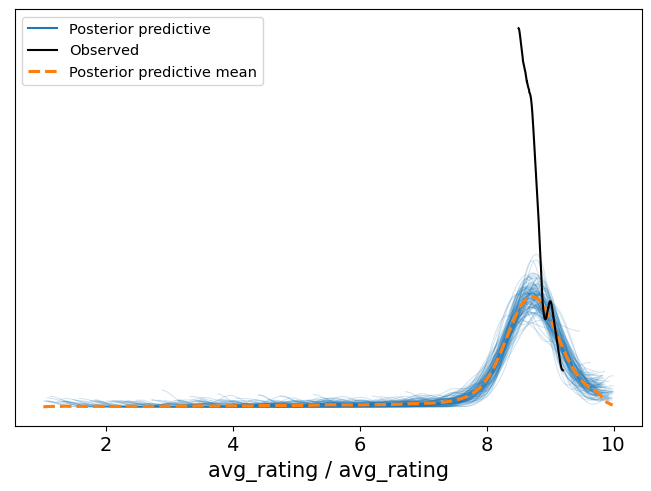

In [43]:
# visualize if model can reproduce the patterns observed in the real data
with model_diffuse:
    pm.sample_posterior_predictive(trace_diffuse, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace_diffuse, num_pp_samples=100);

### Business Questions answered?

**What is the expected average rating for a given genre?**

We found an avg viewer rating for each genre, along with a credible range of what the avg. rating might be (e.g. not a single value, but a distribution of values)


**Understand the differences in ratings between genres**

We can see how the estimated avg. rating differs per genre, how much certainty there is around this avg. rating per genre, and the estimated degree to which dramas within each genre may differ from this avg. rating.


**What genres to invest in?**
- I would recommend _Friendship_ and _Miltary_. 

_Miltary_ has an above average viewer rating and has potential for a very high average rating. But it also contains risk because of the high uncertainty (our dataset only contained 2 obs but both were highly rated). 

_Friendship_ also has an above average viewer rating, and while it's potential avg. rating is not as high as _Military_ it has lower uncertainty.


## Bayesian Hierarchical Logistic Regression

Let's take the problem one set further and create a predicitve model using the Bayesian hierarchcal framework. Using the same dataset, let's create a field called _Success_ and define a "successful" K-drama as one that achieved an average viewer rating over the pooled average, (Rating > 8.72) = Success (coded as 1) and 0 otherwise.

We will incorporate some of our other variables in order to build a predictive model.

#### Business Question:

What is the probability that a drama will be a success?


In [44]:
data.head()

Name  Year of release                   Aired Date  \
0       Move to Heaven             2021                 May 14, 2021   
1    Hospital Playlist             2020  Mar 12, 2020 - May 28, 2020   
2       Flower of Evil             2020  Jul 29, 2020 - Sep 23, 2020   
3  Hospital Playlist 2             2021  Jun 17, 2021 - Sep 16, 2021   
4            My Mister             2018  Mar 21, 2018 - May 17, 2018   

               Aired On  Number of Episode         Network       Duration  \
0                Friday                 10        Netflix         52 min.   
1              Thursday                 12  Netflix,  tvN   1 hr. 30 min.   
2   Wednesday, Thursday                 16            tvN   1 hr. 10 min.   
3              Thursday                 12  Netflix,  tvN   1 hr. 40 min.   
4   Wednesday, Thursday                 16            tvN   1 hr. 17 min.   

                           Content Rating  \
0  18+ Restricted (violence & profanity)    
1                15+ - Teens 15 or older    
2                15+ - Teens 15 or older    
3                15+ - Teens 15 or older    
4                15+ - Teens 15 or older    

                                            Synopsis  \
0  Geu Roo is a young autistic man. He works for ...   
1  The stories of people going through their days...   
2  Although Baek Hee Sung is hiding a dark secret...   
3  Everyday is extraordinary for five doctors and...   
4  Park Dong Hoon is a middle-aged engineer who i...   

                                                Cast  \
0  Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...   
1  Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...   
2  Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...   
3  Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...   
4  Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...   

                                     Genre  \
0                   Life,  Drama,  Family    
1   Friendship,  Romance,  Life,  Medical    
2  Thriller,  Romance,  Crime,  Melodrama    
3   Friendship,  Romance,  Life,  Medical    
4   Psychological,  Life,  Drama,  Family    

                                                Tags Rank  Rating  \
0  Autism, Uncle-Nephew Relationship, Death, Sava...   #1     9.2   
1  Strong Friendship, Multiple Mains, Best Friend...   #2     9.1   
2  Married Couple, Deception, Suspense, Family Se...   #3     9.1   
3  Workplace, Strong Friendship, Best Friends, Mu...   #4     9.1   
4  Age Gap, Nice Male Lead, Strong Female Lead, H...   #5     9.1   

    genre_simple  
0           Life  
1     Friendship  
2       Thriller  
3     Friendship  
4  Psychological

In [45]:
# Create new binary variable "success"
data["success"]=list(map(lambda x: 1 if x > 8.7 else 0, data.Rating))

In [46]:
# counts
data["success"].value_counts()

0    64
1    36
Name: success, dtype: int64

In [47]:
# How many successes by genre
data.groupby( [ "genre_simple", "success"] ).size()


genre_simple   success
Action         0          12
               1           7
Business       0           2
Comedy         0           9
               1           6
Drama          0           1
Food           0           1
Friendship     0           5
               1           4
Historical     0           5
               1           2
Horror         0           3
Life           0           2
               1           1
Military       1           2
Mystery        0           6
               1           2
Psychological  0           4
               1           2
Romance        0           3
Thriller       0          11
               1          10
dtype: int64

In [48]:
# Features: Year of release, Number of Episode, Cast_ParkHyungSik
data["Cast_ParkHyungSik"]=np.where(data["Cast"].str.lower().str.contains("park hyung sik|park hyung-sik"), 1, 0)

In [49]:
data["Cast_ParkHyungSik"].value_counts()

0    98
1     2
Name: Cast_ParkHyungSik, dtype: int64

In [50]:
dataTypeSeries = data.dtypes
print(dataTypeSeries)

Name                  object
Year of release        int64
Aired Date            object
Aired On              object
Number of Episode      int64
Network               object
Duration              object
Content Rating        object
Synopsis              object
Cast                  object
Genre                 object
Tags                  object
Rank                  object
Rating               float64
genre_simple          object
success                int64
Cast_ParkHyungSik      int32
dtype: object


In [51]:
preds=data[["Year of release","Number of Episode","Cast_ParkHyungSik"]]
labels=data.success

In [52]:
with pm.Model() as classifier1:
    
    # Set data (for holdout classification later)
    Xdata = pm.Data('Xdata', preds)
    ydata = pm.Data('ydata', labels)

    # Hyper-Priors
    for_priors_mu_betas=pm.Normal("for_priors_mu_betas", mu=0, sigma=1)
    for_priors_mu_intercept=pm.Normal("for_priors_mu_intercept", mu=0, sigma=1)
    
    for_priors_sd2_betas=pm.InverseGamma("for_priors_sd2_betas", alpha=1, beta=1)
    for_priors_sd2_intercept=pm.InverseGamma("for_priors_sd2_intercept", alpha=1, beta=1)
    
    # Priors
    β = pm.Normal('coefs', mu=for_priors_mu_betas, sigma=pt.sqrt(for_priors_sd2_betas), shape=Xdata.shape[1])
    β0 = pm.Normal('intercept', mu=for_priors_mu_intercept, sigma=pt.sqrt(for_priors_sd2_intercept))

    # Linear combination
    logit_p = β0 + pm.math.dot(Xdata, β)
    logit_proba = pm.Deterministic('proba', logit_p)

    # Likelihood
    _ = pm.Bernoulli('likelihood', logit_p=logit_p, observed=ydata)
    
    # Inference button
    idata = pm.sample(1000, cores=8, return_inferencedata=True)

C:\Users\anneg\anaconda3\lib\site-packages\pymc\data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [for_priors_mu_betas, for_priors_mu_intercept, for_priors_sd2_betas, for_priors_sd2_intercept, coefs, intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 186 seconds.


In [53]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [54]:
classifier1.model

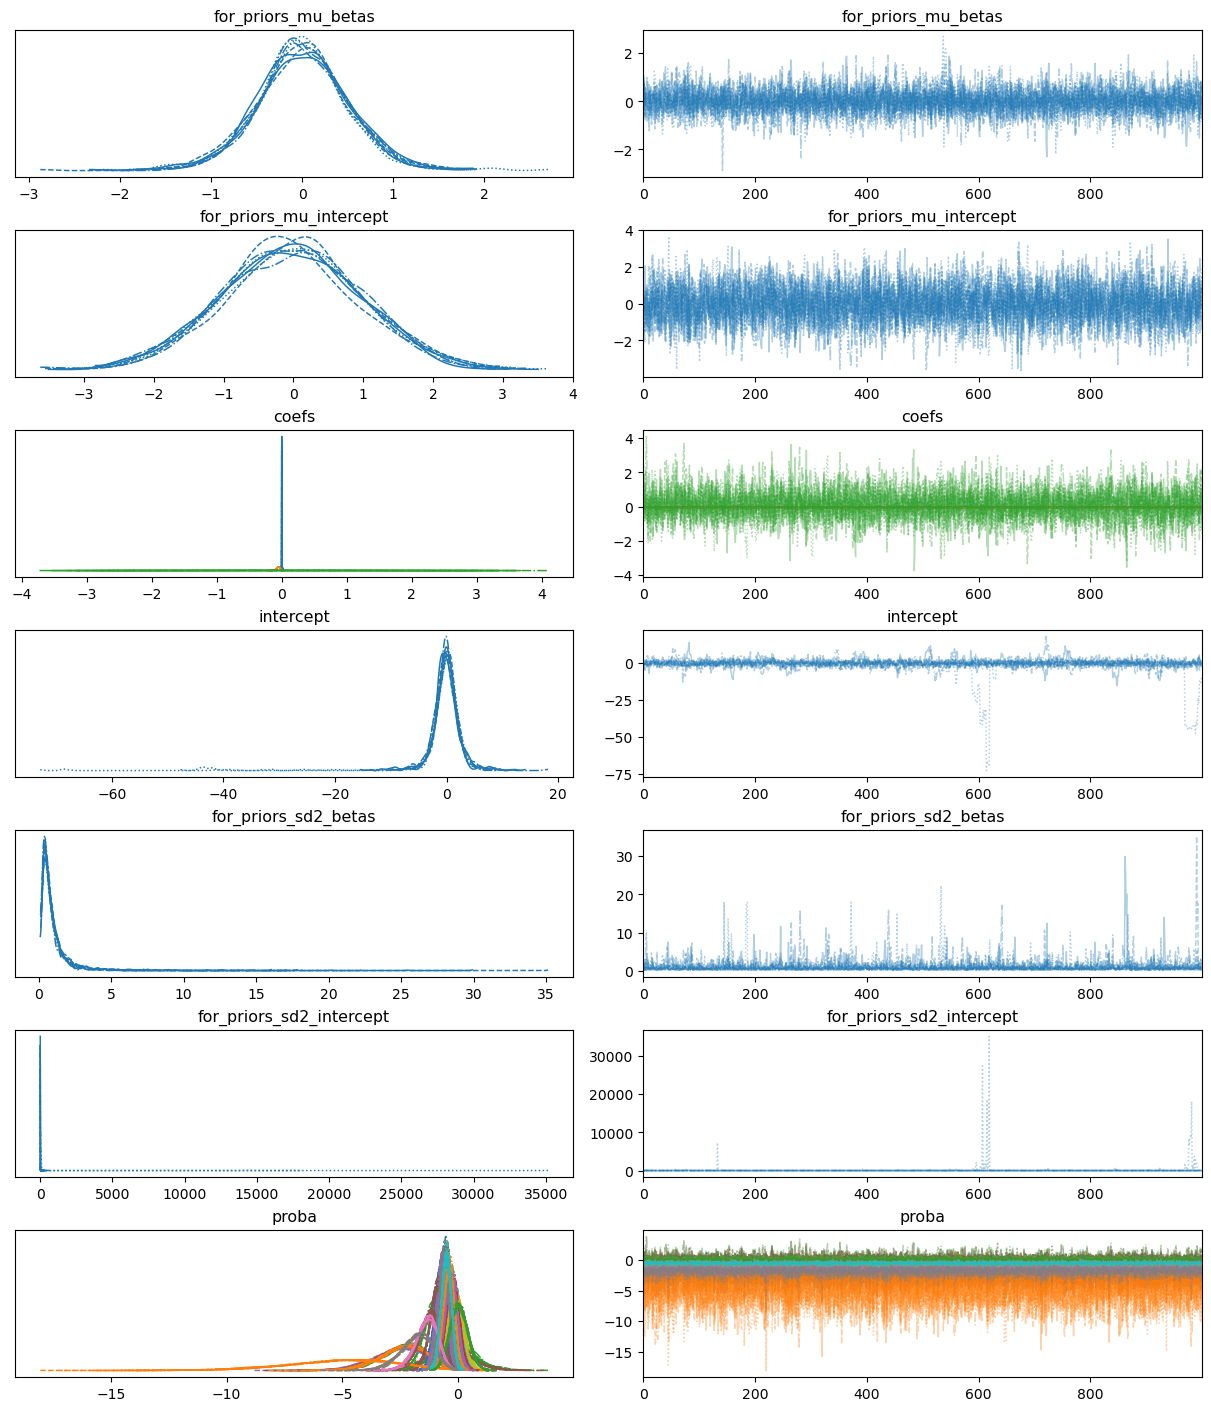

In [55]:
pm.plot_trace(idata);

In [56]:
output_table=pd.DataFrame(az.summary(idata, kind="stats", round_to=2))

In [57]:
output_table

mean    sd  hdi_3%  hdi_97%
for_priors_mu_betas      0.01  0.50   -0.95     0.96
for_priors_mu_intercept -0.03  1.01   -1.91     1.87
coefs[0]                 0.00  0.00   -0.00     0.00
coefs[1]                -0.05  0.03   -0.11    -0.00
coefs[2]                 0.11  0.86   -1.65     1.66
...                       ...   ...     ...      ...
proba[95]               -0.50  0.22   -0.89    -0.09
proba[96]               -1.36  0.48   -2.31    -0.52
proba[97]               -1.79  0.69   -3.14    -0.56
proba[98]               -0.50  0.22   -0.92    -0.12
proba[99]               -0.50  0.22   -0.92    -0.12

[108 rows x 4 columns]

In [58]:
# mean estimated parameter values for log odds model
intercept=output_table.loc["intercept"]["mean"]
beta_year=output_table.loc["coefs[0]"]["mean"]
beta_episodes=output_table.loc["coefs[1]"]["mean"]
beta_ParkHyung=output_table.loc["coefs[2]"]["mean"]

#### Interpretation of coefficients
- The year of the drama has no effect on the view rating
- The number of episodes has a negative influence on viewer rating with an odds ratio of 0.95 (e.g. each additional episodes decreases odds of a success by ~5%)
- Whether or not the drama has actor Park Hyung Sik has a positive influence on rating with an odds ratio of 1.12 (e.g. the odds for a success if he's in the drama are ~12% higher than the odds if he isn't)

In [66]:
# probability prediction of success
def prob_out(year,episodes,ParkHyung):
    logit_odds = intercept + (beta_year*year) + (beta_episodes*episodes) + (beta_ParkHyung*ParkHyung)
    return (1/(1 + math.exp(-1 * ( logit_odds ))))

In [87]:
import math
eps=list(range(1,30,1))
ep_effect=[]

baseline=prob_out(year=0,episodes=0,ParkHyung=0)
for ep in eps:
    #print(ep)
    prob= prob_out(year=0,episodes=ep,ParkHyung=0)
    #print(prob)
    effect_size=prob-baseline
    #print(effect_size)
    ep_effect.append(effect_size)

phs=[0,1]
phs_baseline=prob_out(year=0,episodes=0,ParkHyung=0)
phs_effect=[prob_out(year=0,episodes=0,ParkHyung=0) - phs_baseline,prob_out(year=0,episodes=0,ParkHyung=1) -phs_baseline]

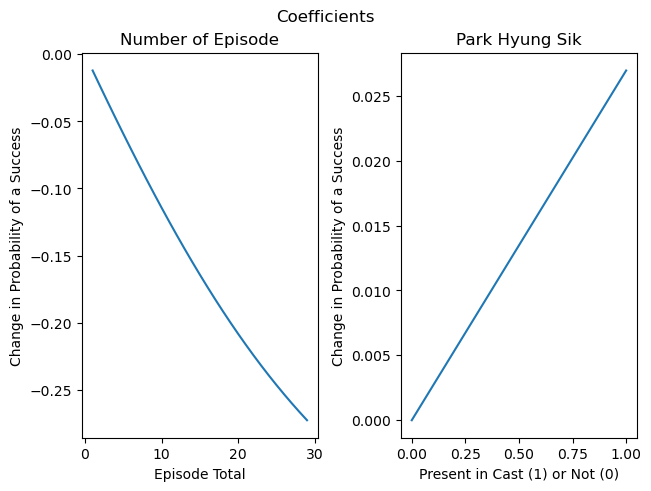

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Coefficients')
ax1.plot(eps,ep_effect)
ax1.set(xlabel='Episode Total', 
                            ylabel='Change in Probability of a Success',
                            title='Number of Episode'
                           )

ax2.plot(phs, phs_effect)
ax2.set(xlabel='Present in Cast (1) or Not (0)', 
        ylabel='Change in Probability of a Success',
       title='Park Hyung Sik')
plt.show()

In [98]:
# example probability of success
print("Probability of a rating over 8.7: " , prob_out(year=2022,episodes=4,ParkHyung=1) * 100, "%")

Probability of a rating over 8.7:  39.41263315682394 %


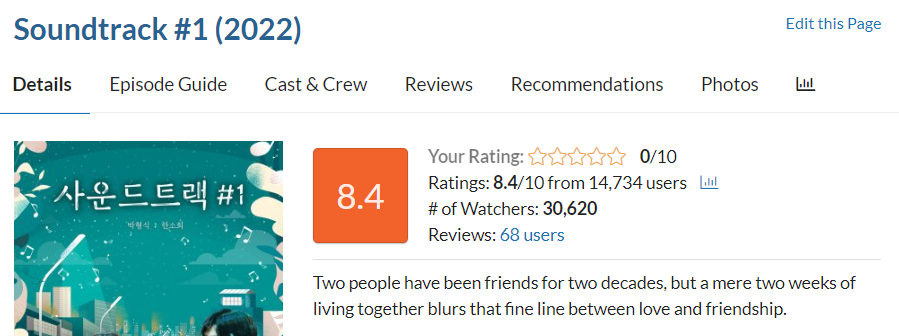

### Appendix

In [ ]:
# Create requirements.txt file
# 1. open Anaconda powershell
# 2. create empty folder that contains .py file of jupyter notebook
# 3. navigate to the folder `cd "C:\Users\anneg\OneDrive - Logic20 20 Inc\Documents\Python Scripts\reqs"`
# 4. type `pipreqs`
# 5. should create a txt file of packages only used by that notebook

In [106]:
"""
with pm.Model(coords=coords) as model_MH:
    # constant data
    #genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor
    # add 'dims' in?

    #dims : str or tuple of str, optional
        #Dimension names of the random variables (as opposed to the shapes of these
        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The
        #``dims`` will then be the name of the Series / DataFrame's columns. See ArviZ
        #documentation for more information about dimensions and coordinates:
        #:ref:`arviz:quickstart`.
        #If this parameter is not specified, the random variables will not have dimension
        #names.
    
    
    # Hyperpriors:
    # x ~ Normal(c,d)
    # y^2 ~ InverseGamma(e,f)
    mu_genre_x = pm.Normal("mu_genre_x", mu=c, sigma=d)  # assign c and d
    sd2_genre_y2 = pm.InverseGamma("sd2_genre_y2", alpha=e, beta=f)  # assign e and f
    #y=sqrt(1/invy2)
    
    # priors / genre-specific parameters:
    # μj ~ Normal(x, y)
    # σ^2 ~ InverseGamma(a,b)
    mu_genre = pm.Normal("mu_genre", mu=mu_genre_x, sigma=sd2_genre_y2, dims="genre")
    sd2_genre=pm.InverseGamma("sd2_genre",alpha=a, beta=b, dims="genre") #define a and b
    #sigma=sqrt(1/invsigma2)
    
    # Create a named deterministic variable
    # ?????
    #avg_rating_by_genre = pm.Deterministic("avg_rating_by_genre", mu_genre, dims="genre")
    #diff_from_avg = pm.Deterministic("diff_from_avg", mu_genre - pt.mean(mu_genre), dims="genre")
    #sd2 = pm.Deterministic("sd2", sd2_genre - pt.mean(sd2_genre), dims="genre")
    
   
    # Expected value per genre:
    genre_avg_rating = mu_genre[genre_idx]
    genre_sd_rating = sd2_genre[genre_idx]
    
    
    # likelihood of observed data
    avg_rating = pm.Normal(
        "avg_rating",
        mu=genre_avg_rating,
        sigma=genre_sd_rating,
        observed=data["Rating"],
        #dims=("drama"),
    )
    

     Uses Metropolis-Hastings sampler
     see https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.Metropolis.html
            Parameters
       ----------
        vars: List of value variables for sampler
        S: standard deviation or covariance matrix
            Some measure of variance to parameterize proposal distribution
        proposal_dist: Function that returns zero-mean deviates when parameterized with S (and n). Defaults to normal.
        scaling: Initial scale factor for proposal. Defaults to 1.
        tune:  Flag for tuning. Defaults to True.
        tune_interval:  The frequency of tuning. Defaults to 100 iterations.
        model:  Optional model for sampling step. Defaults to None (taken from context).
        mode:  compilation mode passed to PyTensor functions

    steps = pm.Metropolis(vars=[mu_genre_x,sd2_genre_y2,mu_genre,sd2_genre],tune_interval=1000)
    trace_MH = pm.sample(1000,step=steps, progressbar=True)
"""

'\nwith pm.Model(coords=coords) as model_MH:\n    # constant data\n    #genre_cat = pm.ConstantData("genre_cat", genre_idx, dims="drama") # Data container that registers a data variable with the model as a tensor\n    # add \'dims\' in?\n\n    #dims : str or tuple of str, optional\n        #Dimension names of the random variables (as opposed to the shapes of these\n        #random variables). Use this when ``value`` is a pandas Series or DataFrame. The\n        #``dims`` will then be the name of the Series / DataFrame\'s columns. See ArviZ\n        #documentation for more information about dimensions and coordinates:\n        #:ref:`arviz:quickstart`.\n        #If this parameter is not specified, the random variables will not have dimension\n        #names.\n    \n    \n    # Hyperpriors:\n    # x ~ Normal(c,d)\n    # y^2 ~ InverseGamma(e,f)\n    mu_genre_x = pm.Normal("mu_genre_x", mu=c, sigma=d)  # assign c and d\n    sd2_genre_y2 = pm.InverseGamma("sd2_genre_y2", alpha=e, beta=f)  #

In [76]:
"""
(
    data.groupby("genre_simple")["Rating"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of viewer ratings by genre",
        yerr=data.groupby("genre_simple")["Rating"].std(),
        color=colors[3],
        ylim=(data.Rating.min() - 1, 10),
    )
    .set_ylabel("Average Rating Value")
);
"""

'\n(\n    data.groupby("genre_simple")["Rating"]\n    .mean()\n    .plot(\n        kind="bar",\n        title="Average magnitude of viewer ratings by genre",\n        yerr=data.groupby("genre_simple")["Rating"].std(),\n        color=colors[3],\n        ylim=(data.Rating.min() - 1, 10),\n    )\n    .set_ylabel("Average Rating Value")\n);\n'